## 基本文本分类： IMDB 电影评论文本分类

In [1]:
import sys
import os

import tensorflow as tf 
from tensorflow import keras
import numpy as np

print("python version: ", sys.version_info)
for module in np, tf, keras:
    print(module.__name__, "version: ", module.__version__)
    
seed = 10383

python version:  sys.version_info(major=3, minor=7, micro=2, releaselevel='final', serial=0)
numpy version:  1.16.0
tensorflow version:  2.3.0
tensorflow.keras version:  2.4.0


### 1. 加载 IMDB 数据集  

In [2]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

保留了训练数据中最常出现的 10,000 个单词。为了保持数据规模的可管理性，低频词将被丢弃。

### 2. 探索数据

该数据集是经过预处理的：每个样本都是一个表示影评中词汇的整数数组。  
每个标签都是一个值为 0 或 1 的整数值，其中 0 代表消极评论，1 代表积极评论。  

In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


评论文本被转换为整数值，其中每个整数代表词典中的一个单词。首条评论是这样的：

In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


电影评论可能具有不同的长度。以下代码显示了第一条和第二条评论的中单词数量。  
由于神经网络的输入必须是统一的长度，我们稍后需要解决这个问题。  

In [5]:
len(train_data[0]), len(train_data[1])

(218, 189)

#### 2.1 将整数转回单词

In [6]:
# 一个映射单词到整数索引的词典
word_index = imdb.get_word_index()

# 保留第一个索引
word_index = {k: v + 3 for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2 # unknown
word_index["<END>"] = 3

reverse_word_index = {value: key for key, value in word_index.items()}


def decode_review(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])

显示首条评论的文本：

In [7]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

### 3. 准备数据

In [8]:
train_data = keras.preprocessing.sequence.pad_sequences(
    train_data, value=word_index["<PAD>"], padding="post", maxlen=256
)
test_data = keras.preprocessing.sequence.pad_sequences(
    test_data, value=word_index["<PAD>"], padding="post", maxlen=256
)

In [9]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [10]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

### 4. 构建模型

In [11]:
# 输入形状是用于电影评论的词汇数目（10,000 词）
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


1. 第一层是嵌入（Embedding）层。该层采用整数编码的词汇表，并查找每个词索引的嵌入向量（embedding vector）。这些向量是通过模型训练学习到的。向量向输出数组增加了一个维度。得到的维度为：(batch, sequence, embedding)。  
2. 接下来，GlobalAveragePooling1D 将通过对序列维度求平均值来为每个样本返回一个定长输出向量。这允许模型以尽可能最简单的方式处理变长输入。  
3. 该定长输出向量通过一个有 16 个隐层单元的全连接（Dense）层传输。  
4. 最后一层与单个输出结点密集连接。使用 Sigmoid 激活函数，其函数值为介于 0 与 1 之间的浮点数，表示概率或置信度。  

#### 4.1 隐层单元

上述模型在输入输出之间有两个中间层或“隐藏层”。输出（单元，结点或神经元）的数量即为层表示空间的维度。  
  
如果模型具有更多的隐层单元（更高维度的表示空间）和/或更多层，则可以学习到更复杂的表示。但是，这会使网络的计算成本更高，并且可能导致学习到不需要的模式——一些能够在训练数据上而不是测试数据上改善性能的模式。这被称为过拟合（overfitting），我们稍后会对此进行探究。

#### 4.2 损失函数和优化器

In [12]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

### 5. 创建一个验证集

在训练时，我们想要检查模型在未见过的数据上的准确率（accuracy）。通过从原始训练数据中分离 10,000 个样本来创建一个验证集。（为什么现在不使用测试集？我们的目标是只使用训练数据来开发和调整模型，然后只使用一次测试数据来评估准确率（accuracy））。

In [13]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

### 6. 训练模型

In [14]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
118/118 [==============================] - 1s 5ms/step - loss: 0.6824 - accuracy: 0.6391 - val_loss: 0.6590 - val_accuracy: 0.7556
Epoch 2/40
118/118 [==============================] - 0s 4ms/step - loss: 0.5984 - accuracy: 0.7855 - val_loss: 0.5372 - val_accuracy: 0.8135
Epoch 3/40
118/118 [==============================] - 0s 4ms/step - loss: 0.4585 - accuracy: 0.8515 - val_loss: 0.4188 - val_accuracy: 0.8510
Epoch 4/40
118/118 [==============================] - 1s 4ms/step - loss: 0.3524 - accuracy: 0.8834 - val_loss: 0.3550 - val_accuracy: 0.8637
Epoch 5/40
118/118 [==============================] - 0s 3ms/step - loss: 0.2899 - accuracy: 0.9001 - val_loss: 0.3167 - val_accuracy: 0.8781
Epoch 6/40
118/118 [==============================] - 0s 4ms/step - loss: 0.2491 - accuracy: 0.9119 - val_loss: 0.2980 - val_accuracy: 0.8824
Epoch 7/40
118/118 [==============================] - 0s 3ms/step - loss: 0.2186 - accuracy: 0.9239 - val_loss: 0.2888 - val_accuracy: 0.8854
Epoch 

### 7. 评估模型

In [15]:
results = model.evaluate(test_data,  test_labels, verbose=2)

print(results)

782/782 - 0s - loss: 0.6988 - accuracy: 0.8494
[0.6988406181335449, 0.8494399785995483]


### 8. 绘制训练过程图

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

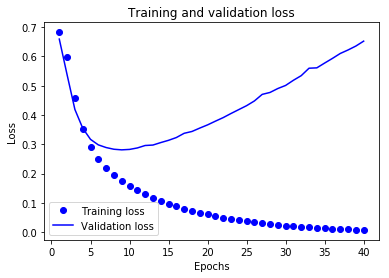

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"代表 "蓝点"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b代表"蓝色实线"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

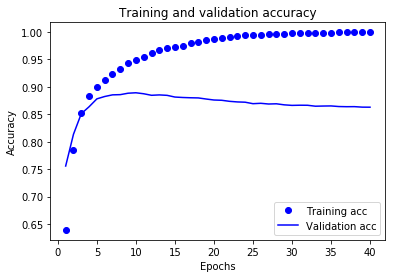

In [19]:
plt.clf()   # 清除数字

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()